In [33]:
import os
import sys 
sys.path.append("/Users/johnzhou/research/decision-making")

import numpy as np
from scipy.optimize import minimize

from src.data.environments import DynamicForagingTask
from src.data.generate_synth_data import SIGMOID_PARAM_BOUNDS
from src.data.experiments import RealExperiment
from src.features.build_features import sigmoid_initial_guess, compute_foraging_efficiency, driver_func
from src.utils import blockify, build_config, normalize_block_side, average_blocks, truncate_blocks

In [21]:
directory = "/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/"
filenames = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
    print(f)

/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR17_DynamicForaging_20221006_160204.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR16_DynamicForaging_20221011_132928.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR16_DynamicForaging_20221006_152352.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR15_DynamicForaging_20221007_160954.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR17_DynamicForaging_20221007_164236.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR16_DynamicForaging_20221012_110414.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR18_DynamicForaging_20221011_141239.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR15_DynamicForaging_20221011_132938.mat
/Users/johnzhou/research/decision-making/data/real/dynamic_foraging/MR15_DynamicForaging_20221010_135246.mat
/Users/johnzhou/res

In [40]:
trial_feats = []
sig_feats = []
failed_fits = 0
num_blocks = 0

for filename in filenames:
#     try:
    expt = RealExperiment(filename, task_type=DynamicForagingTask)
#     except ValueError:
#         print(f"Failed to load {filename}")
#         continue
    
    blocks = expt.blocks
    num_blocks += len(blocks)
    actions = expt.action_history
    rewards = expt.reward_history
    blocked_actions = blockify(expt.blocks, actions)
    blocked_rewards = blockify(expt.blocks, rewards)
    normalized_actions = [normalize_block_side(blocked_actions[block_idx], blocks[block_idx][0])
                          for block_idx in range(len(blocks))]
    truncated_actions = truncate_blocks(normalized_actions)
    
    for i in range(len(blocks)):
        if blocks[i][2] < 15:
            print(f"too short, only {blocks[i][2]}")
            continue
        action_block = truncated_actions[i]
        reward_block = rewards[i]
        E = compute_foraging_efficiency(action_block, reward_block)

        x_obs = np.arange(len(action_block))
        y_obs = np.array(action_block)

        trial_feats.append(y_obs)

        try:
            params = scipy.optimize.minimize(driver_func, sigmoid_initial_guess(y_obs), args=(x_obs, y_obs),
                                             bounds=SIGMOID_PARAM_BOUNDS).x
            sig_feats.append(np.array([*params, E]))
        except RuntimeError:
            failed_fits += 1

print(f"Failed to fit {failed_fits} blocks :(")


too short, only 8
too short, only 6
too short, only 10
too short, only 8
too short, only 2
too short, only 1
too short, only 8
too short, only 6
Failed to fit 0 blocks :(


In [46]:
sig_feats = np.array(sig_feats)
trial_feats = np.array(trial_feats)
np.save(f"{directory}real_sig_feats.npy", sig_feats)
np.save(f"{directory}real_trial_feats.npy", sig_feats)

[ 0.28571428 10.32578181  0.        ]


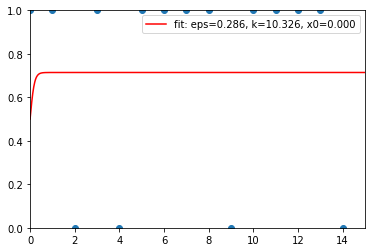

[ 0.42857917 16.0446724   0.        ]


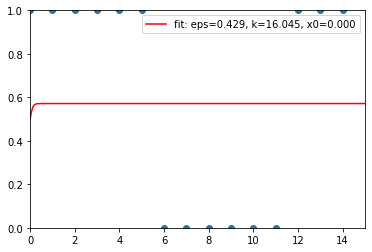

[ 0.46666733 34.94475332  0.48364299]


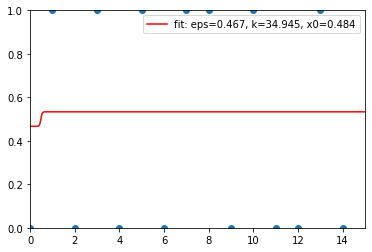

[ 0.         14.25578388  4.49968095]


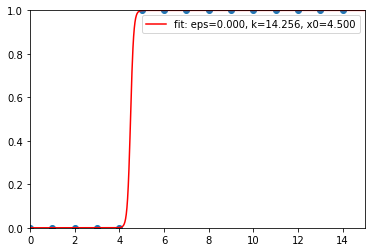

[0.24858478 0.83590995 0.        ]


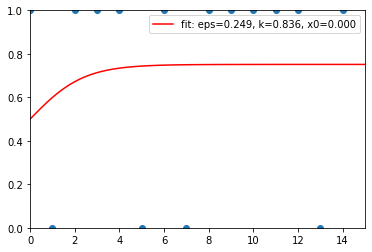

[ 0.33334347 33.30085363  4.53960109]


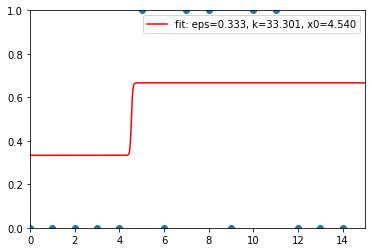

[ 0.33333323 27.29087882  0.52213823]


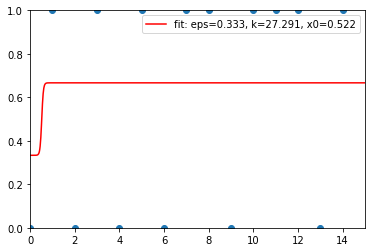

[ 0.         14.25578529  9.49968098]


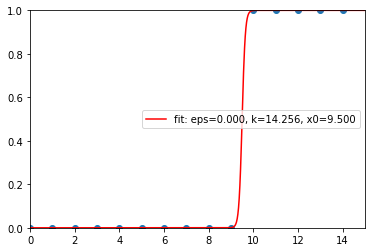

[ 0.13333316 25.28989148  1.50190009]


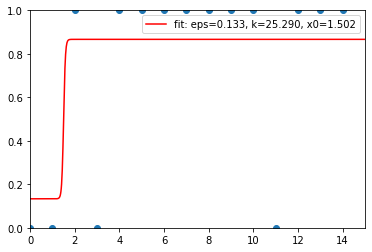

[ 0.06665797 37.7581406   5.4351282 ]


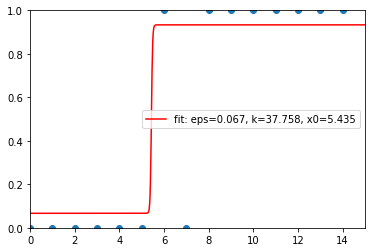

[ 0.06666657 34.16199066  0.53691186]


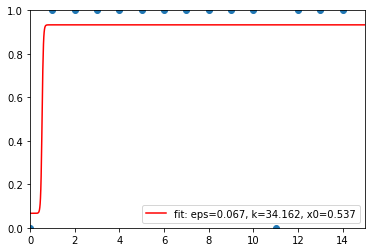

[2.00000002e-01 3.03960714e+02 1.42597043e+01]


/Users/johnzhou/research/decision-making/src/features/build_features.py:64: RuntimeWarning: overflow encountered in exp
  return np.float64(eps + (1 - 2 * eps) / (1 + np.exp(-alpha * (X - s))))


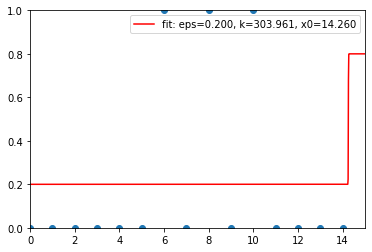

[ 0.21428571 10.26939271  0.        ]


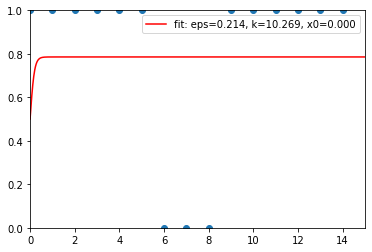

[ 0.         14.25710676  0.49960748]


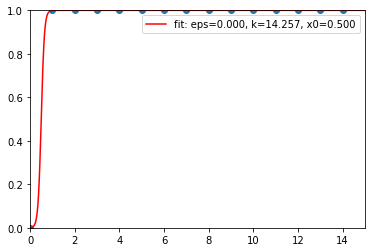

[ 0.         14.25548605 12.49968069]


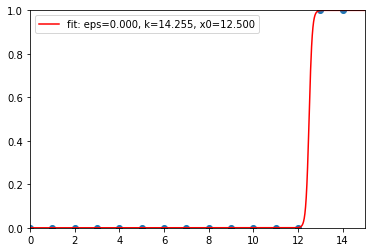

[ 0.06666666 49.23319706  1.3233843 ]


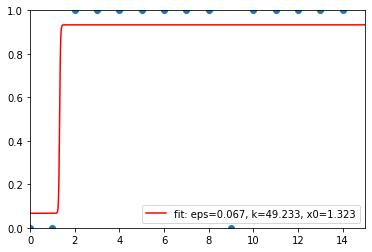

[ 0.26666672 31.04479822  0.51164071]


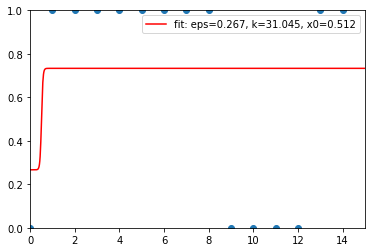

[ 0.0666642  35.74448279  0.54208859]


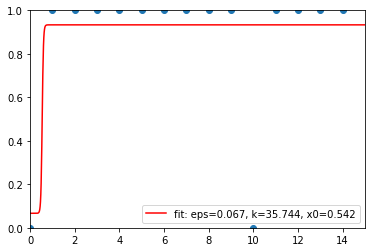

[ 0.         14.25710676  0.49960748]


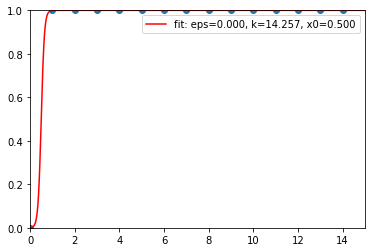

[ 0.07142922 17.07013617  0.        ]


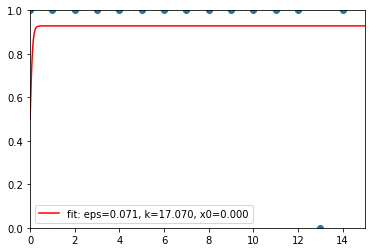

[ 0.42861897 20.44644064  0.        ]


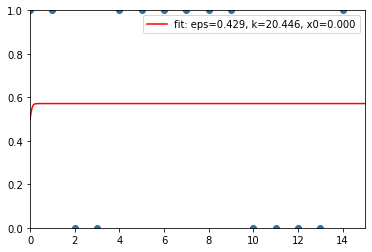

[0.5        5.00318892 1.25027385]


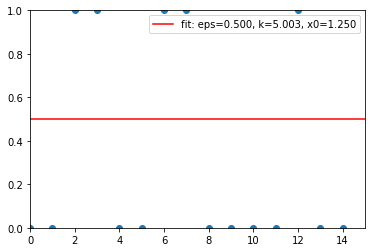

[ 0.          5.0127729  15.41953986]


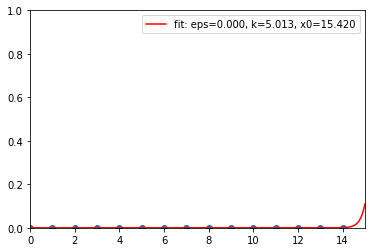

[ 0.33333475 62.0390824   1.49319711]


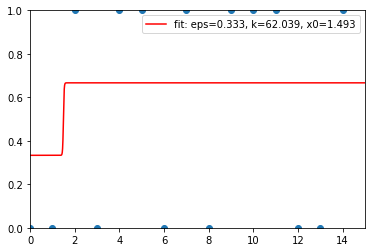

[ 0.         14.25582263  6.49968055]


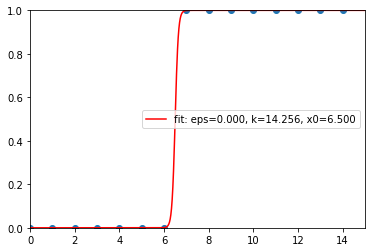

[ 0.26666979 32.85123853  1.48906272]


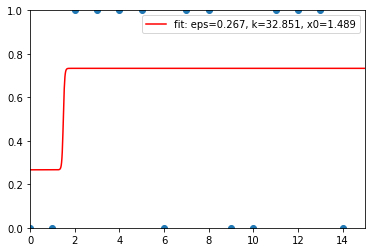

[ 0.         14.25582263  6.49968055]


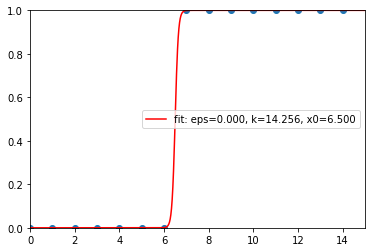

[ 0.14285714 11.61210518  0.        ]


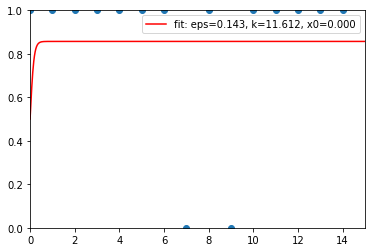

[ 0.06666848 43.68182337  4.42127923]


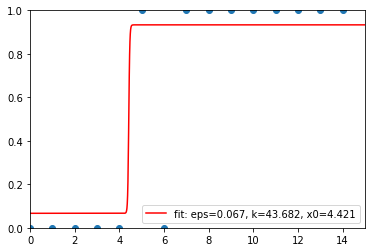

[ 0.14285713 11.59583666  0.        ]


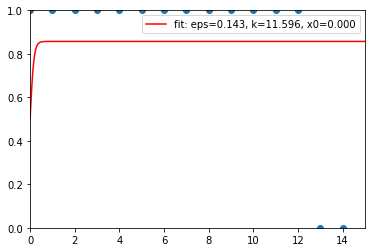

[ 0.20000941 35.49895398  1.50357624]


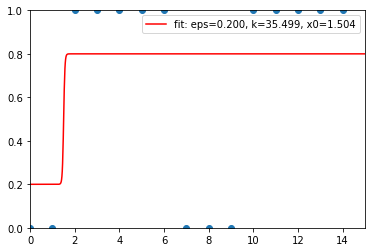

[ 0.42857141 16.90213989  0.        ]


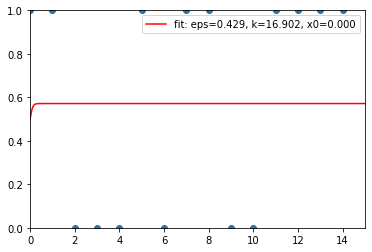

[ 0.06666689 42.39170873  0.54672437]


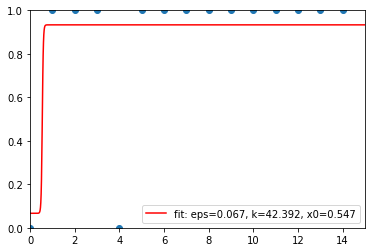

[ 0.13333317 25.25949415  1.50143116]


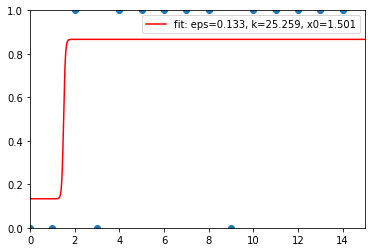

[0.01041765 0.22077723 0.0200651 ]


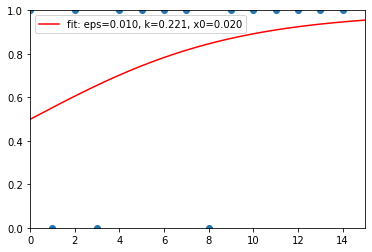

[ 0.         14.25584404  1.49967996]


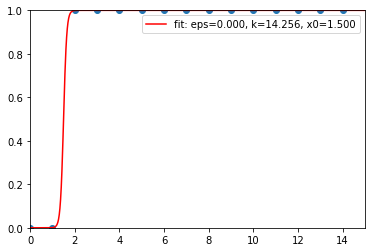

[ 0.14285714 11.60040251  0.        ]


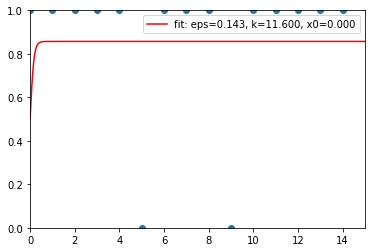

[ 0.1333328  25.22062143  6.49952076]


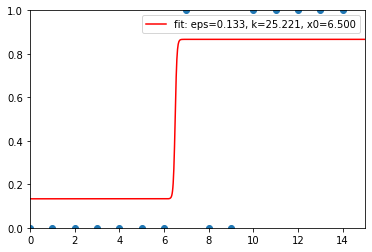

[ 0.         14.25578388  4.49968095]


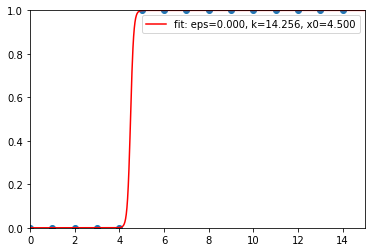

[ 0.06666682 33.14219247  1.44307479]


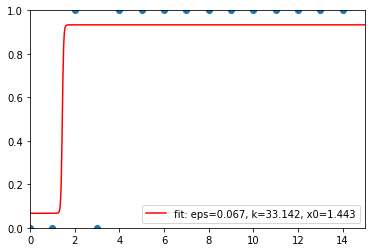

[ 0.         14.2557828   5.49968089]


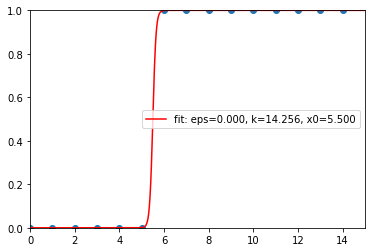

[0.         0.63880004 0.        ]


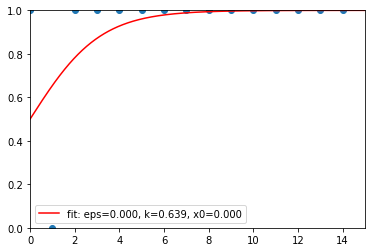

[ 0.26663139 32.12461984  0.51401748]


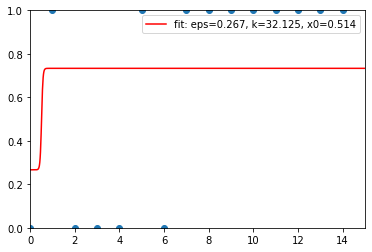

[ 0.26666666 35.88360892  3.52861559]


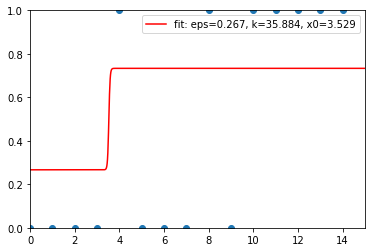

[ 0.         14.2557828   5.49968089]


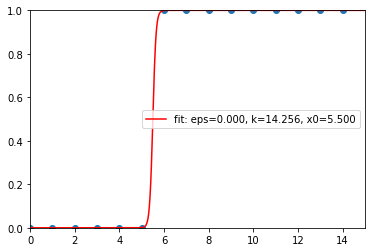

[ 0.19999978 34.3879064   1.50592891]


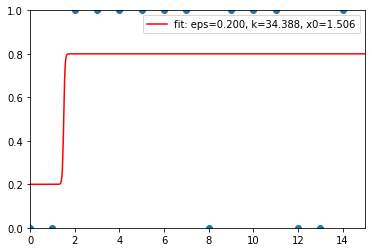

[0.         6.21170291 0.        ]


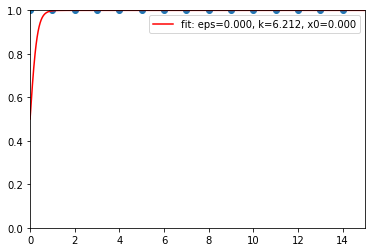

[ 0.20000001 29.33386749  1.50785492]


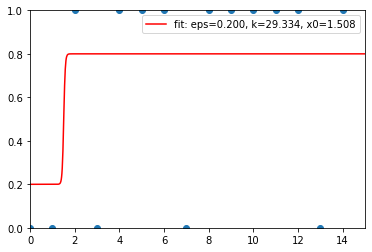

[ 0.21428571 10.26904639  0.        ]


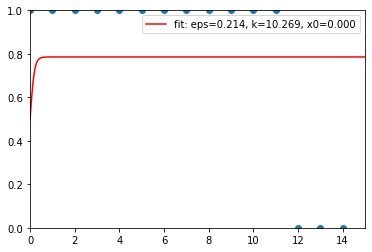

[ 0.0714288  17.03668286  0.        ]


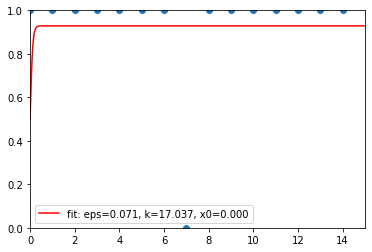

[ 0.06666635 31.5031326   3.43597689]


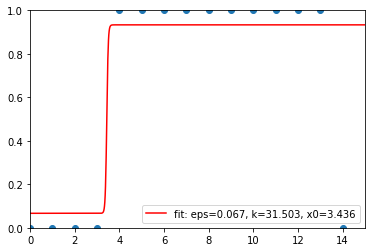

[ 0.1333349  48.29876549  0.6737931 ]


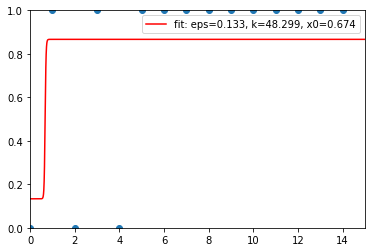

[ 0.46666721 32.9948527   1.51173881]


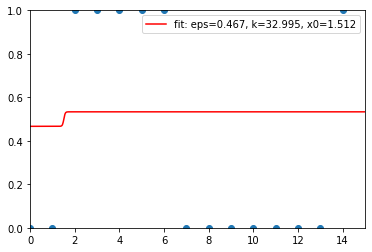

[ 0.21428571 10.26904639  0.        ]


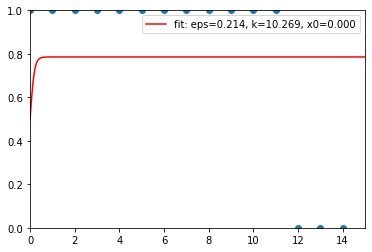

[ 0.13332049 42.43517899  2.64775336]


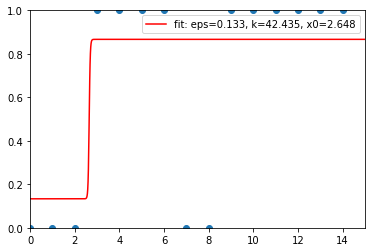

[ 0.         14.25710676  0.49960748]


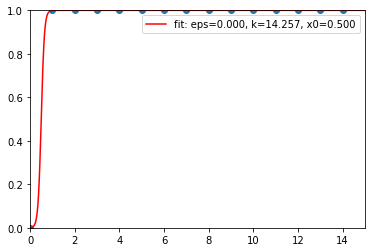

[ 0.06666542 47.86112199  2.39312512]


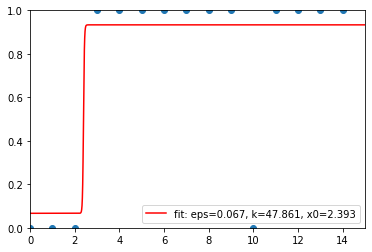

[0.5        5.0032772  0.24994504]


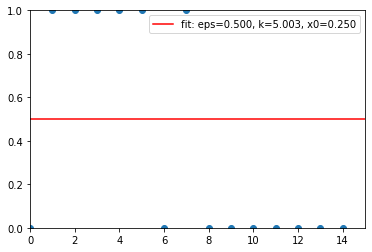

[0.         6.21170291 0.        ]


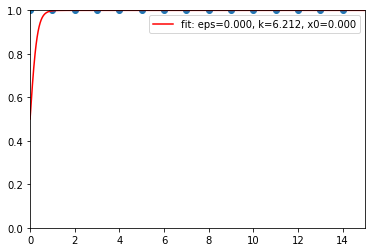

[ 0.         14.25584404  1.49967996]


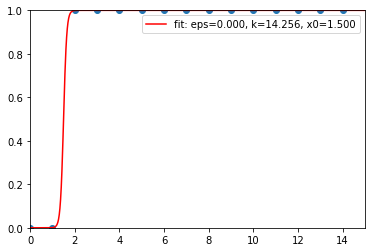

[ 0.         14.25584404  1.49967996]


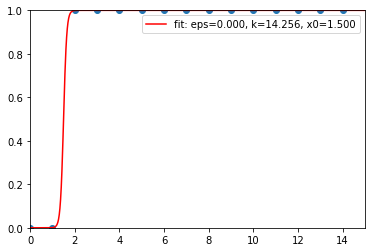

[ 0.         14.25584404  1.49967996]


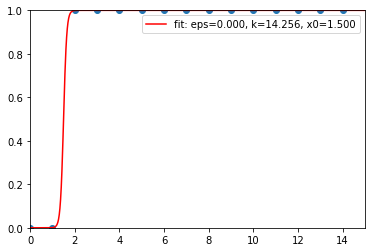

[ 0.         14.25584404  1.49967996]


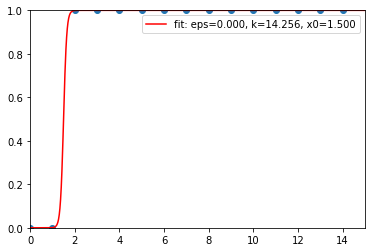

[ 0.20000082 34.5093038   1.52264889]


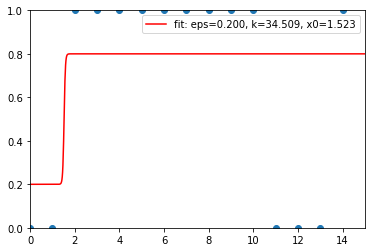

[ 0.         14.25582262  3.49968065]


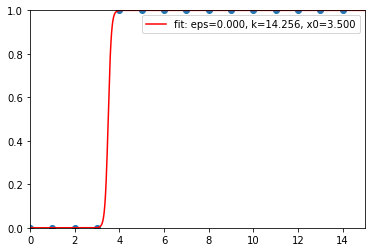

[ 0.         14.25578388  4.49968095]


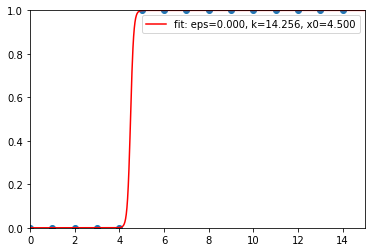

[ 0.         14.25710676  0.49960748]


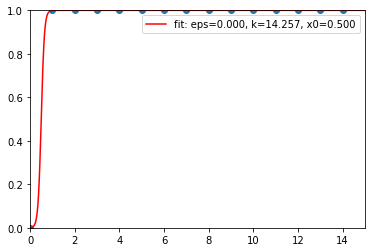

[ 0.20004301 35.94742043  0.50324824]


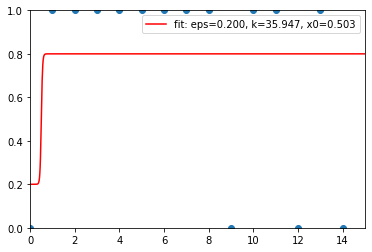

[ 0.06666523 35.40170525  0.54175525]


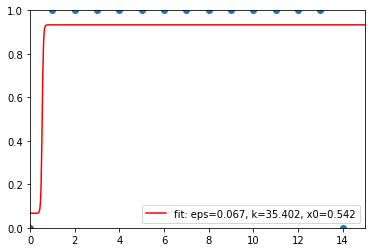

[ 0.         14.25710676  0.49960748]


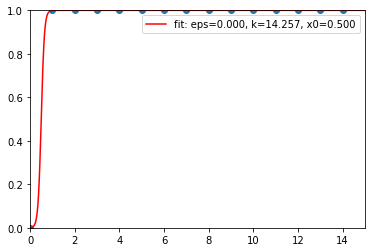

[ 0.06666671 32.11352297  1.4295463 ]


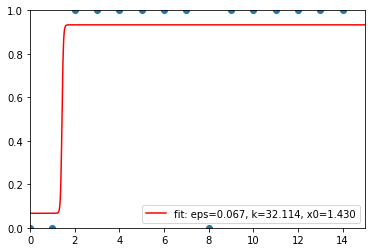

[ 0.         14.25578529  9.49968098]


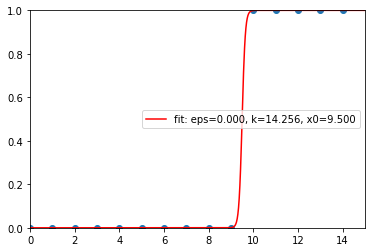

[ 0.         14.25581074  7.49968071]


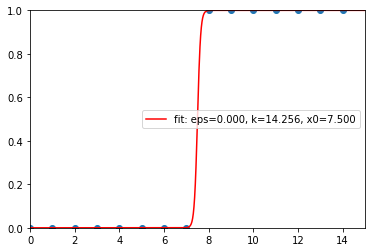

[ 0.07142922 17.07013617  0.        ]


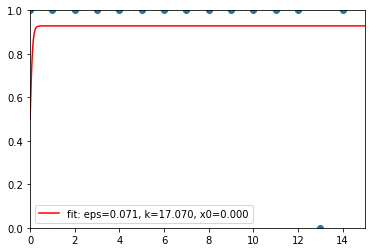

[ 0.46666929 21.21121344  6.50353957]


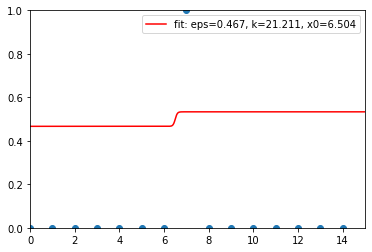

[ 0.         14.25584404  1.49967996]


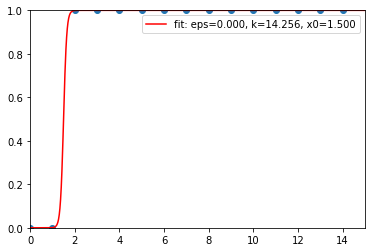

[ 0.         14.2557828   5.49968089]


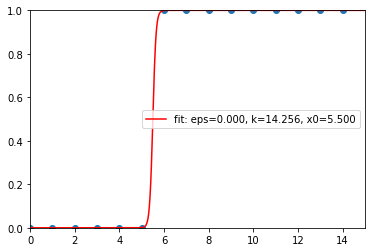

[ 0.         14.25584404  1.49967996]


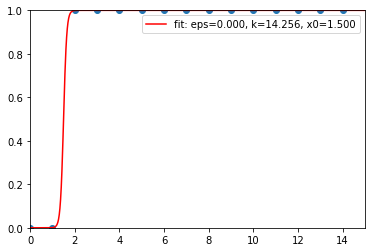

[ 0.         14.2557828   5.49968089]


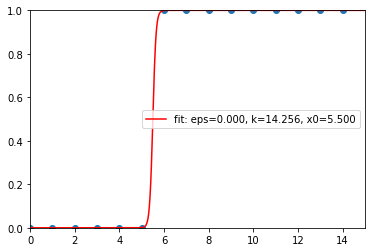

[ 0.         14.25710676  0.49960748]


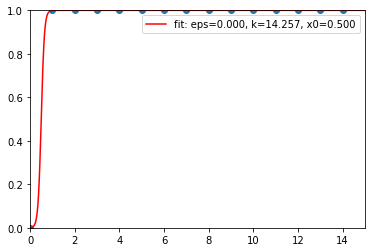

[ 0.         14.25580944  2.49968072]


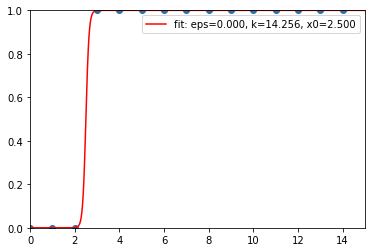

[ 0.20000002 26.27994986  0.50133666]


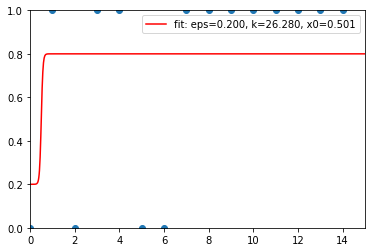

[ 0.         14.25584404  1.49967996]


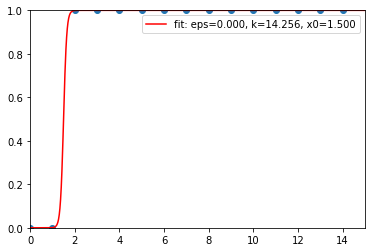

[ 0.         14.25710676  0.49960748]


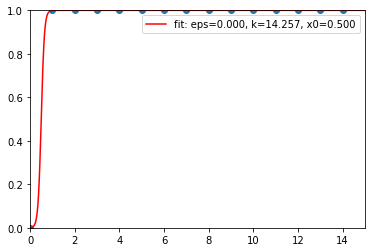

[ 0.13333262 45.21777927  0.66267496]


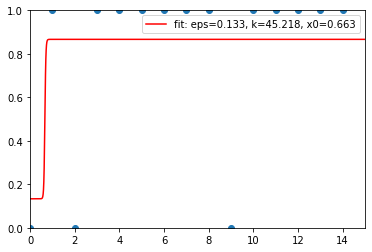

[ 0.06666523 35.40170525  0.54175525]


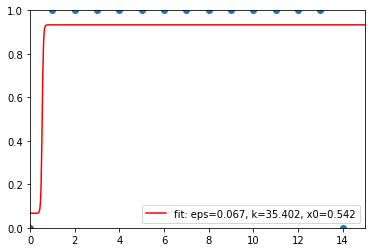

[ 0.         14.25584404  1.49967996]


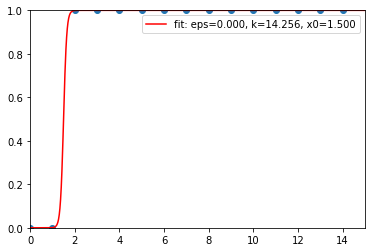

[ 0.         14.25710676  0.49960748]


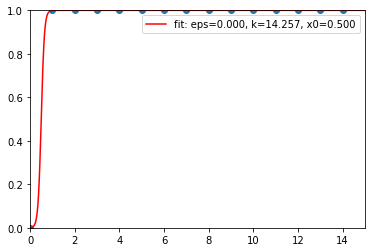

[ 0.         14.25710676  0.49960748]


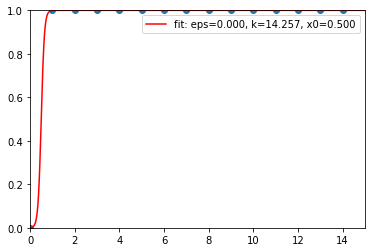

[ 0.         14.25581134  8.49968077]


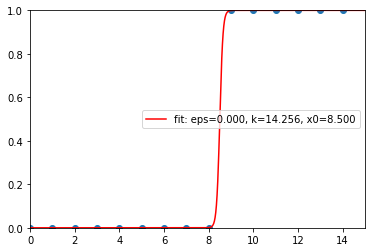

[ 0.         14.25584404  1.49967996]


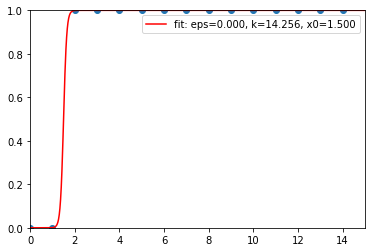

[ 0.         14.25582262  3.49968065]


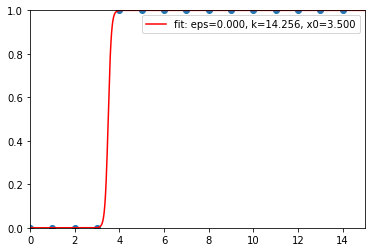

[ 0.06666684 42.93509054  1.34898504]


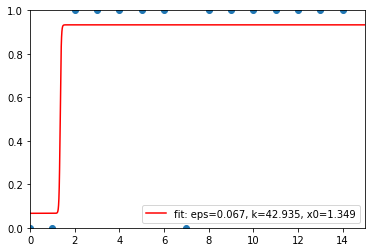

[ 0.          5.0127729  15.41953986]


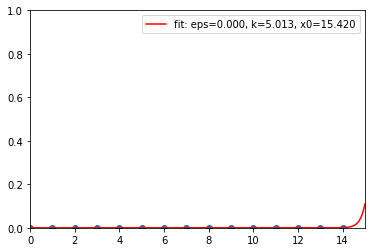

[ 0.06666701 34.26784302  0.53342095]


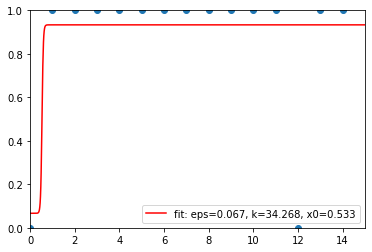

[ 0.          5.0127729  15.41953986]


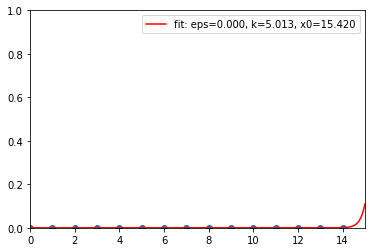

[ 0.         14.25710676  0.49960748]


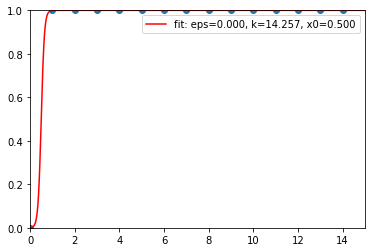

[ 0.         14.25578388  4.49968095]


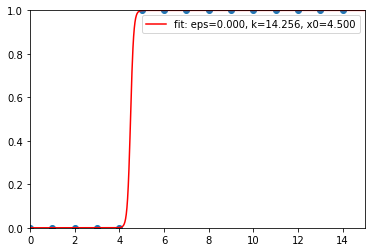

[ 0.         14.25710676  0.49960748]


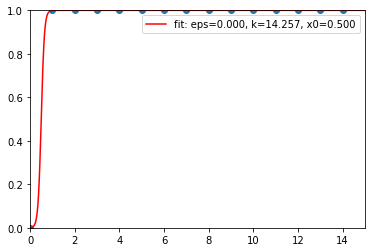

[ 0.         14.2557828   5.49968089]


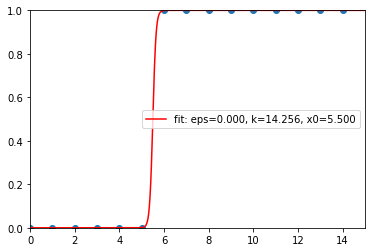

[ 0.          5.0127729  15.41953986]


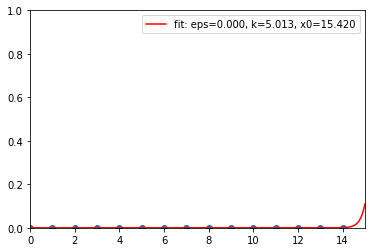

[ 0.13334698 33.003366    2.59020912]


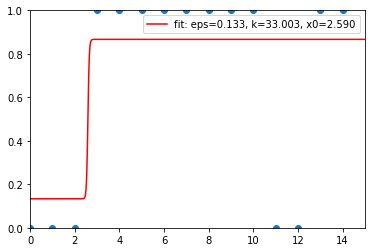

[ 0.         14.25710676  0.49960748]


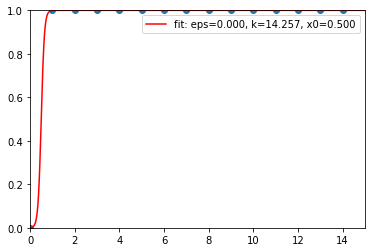

[ 0.         14.25580944  2.49968072]


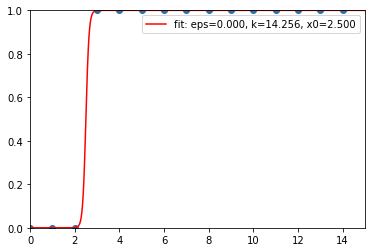

[ 0.         14.25710676  0.49960748]


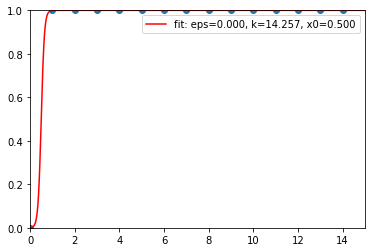

[ 0.19999995 26.11460288 10.50398682]


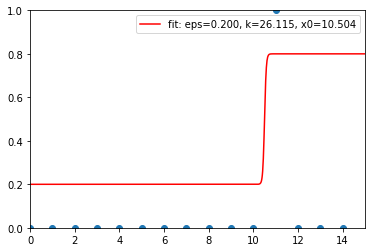

[ 0.14285714 11.60455286  0.        ]


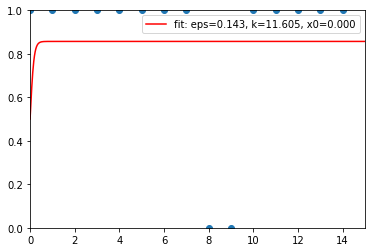

[ 0.06666665 33.88704906  0.53474386]


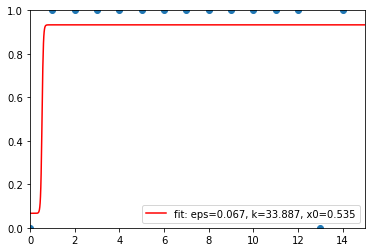

[ 0.          5.0127729  15.41953986]


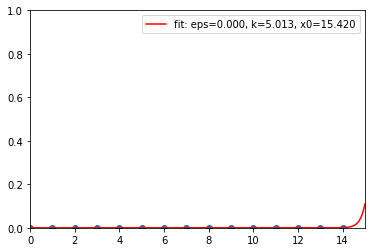

[ 0.06666662 29.39445028  0.46734624]


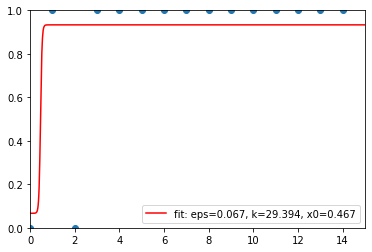

[0.         6.21170291 0.        ]


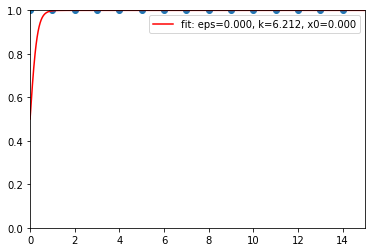

[ 0.         14.25710676  0.49960748]


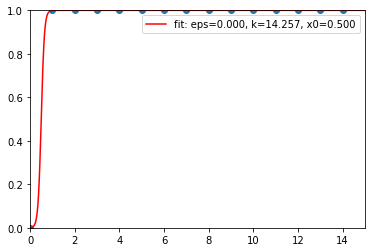

[ 0.          5.0127729  15.41953986]


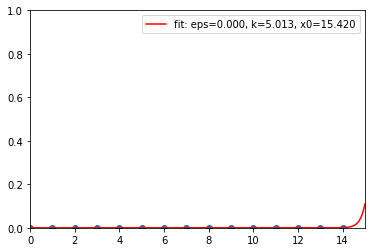

[ 0.         14.25710676  0.49960748]


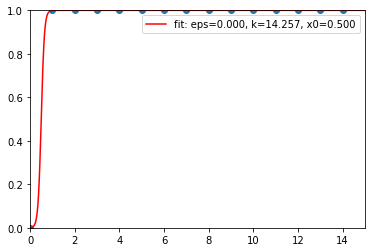

[ 0.         14.25582262  3.49968065]


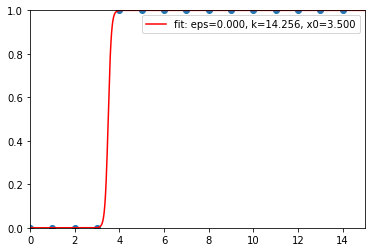

[ 0.         14.25710676  0.49960748]


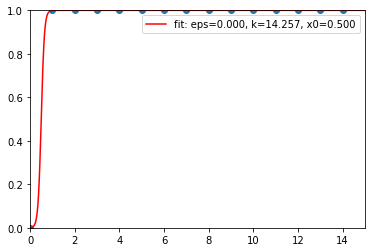

[ 0.         14.25582262  3.49968065]


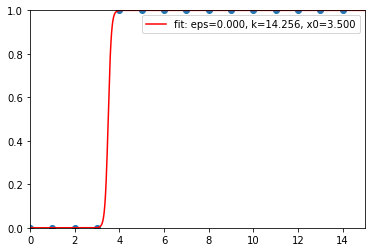

[ 0.         14.25710676  0.49960748]


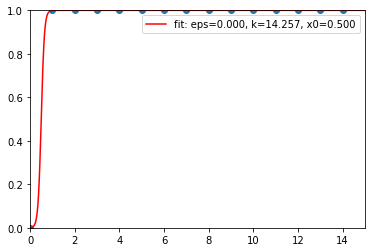

[ 0.         14.25578388  4.49968095]


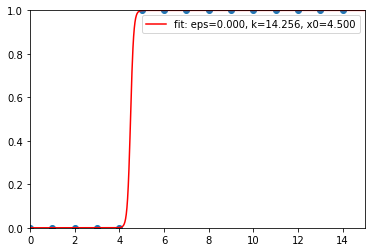

[ 0.         14.25710676  0.49960748]


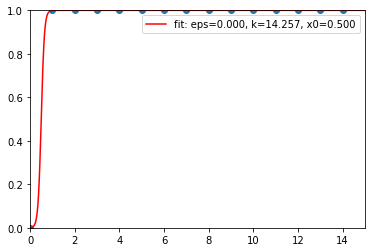

[0.         6.21170291 0.        ]


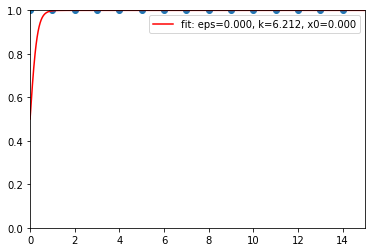

[ 0.06666662 29.39445028  0.46734624]


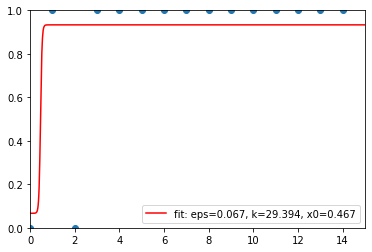

[0.5        5.00327702 0.24994504]


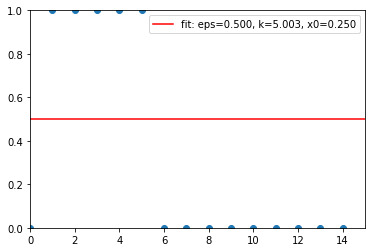

[ 0.         14.25582263  6.49968055]


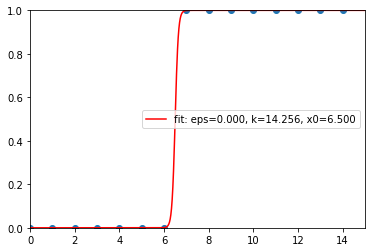

[ 0.         14.25710676  0.49960748]


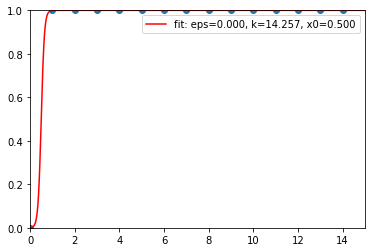

[ 0.20000209 32.5050308   2.50199921]


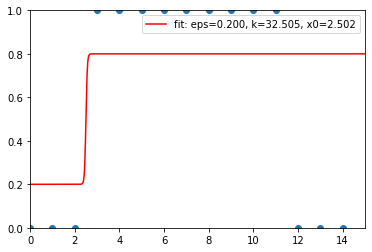

[ 0.26663139 32.12461984  0.51401748]


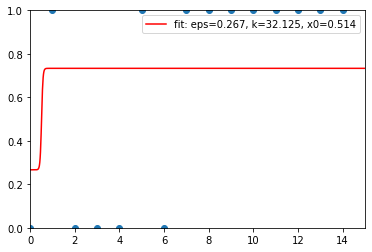

[ 0.13333314 38.02959     1.55466514]


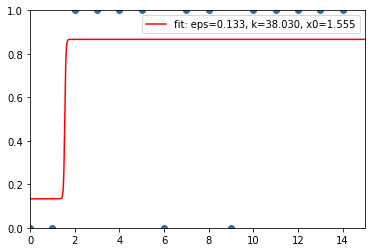

[ 0.         14.25710676  0.49960748]


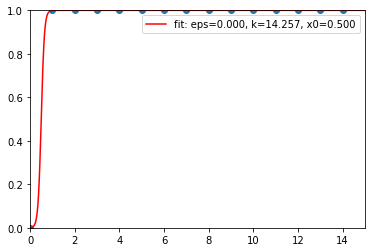

[ 0.          5.0127729  15.41953986]


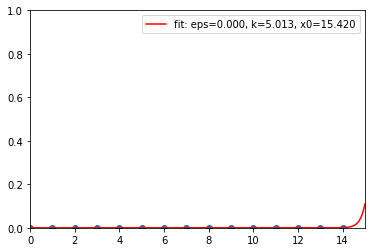

[ 0.07143954 16.54616663  0.        ]


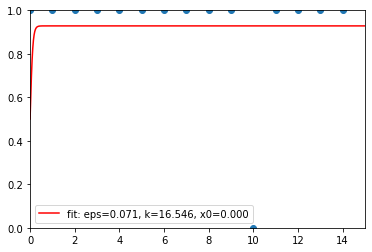

[ 0.13333348 29.63058348  0.54160326]


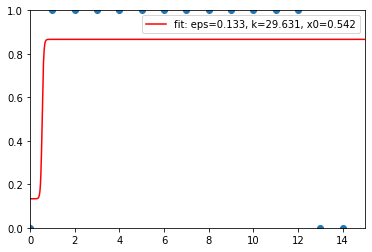

[ 0.13333285 25.30471715  5.49969391]


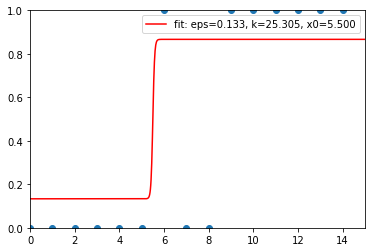

[ 0.14285715 11.61199428  0.        ]


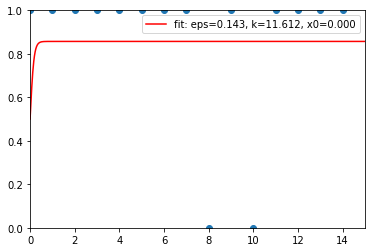

[ 0.07143739 16.57482924  0.        ]


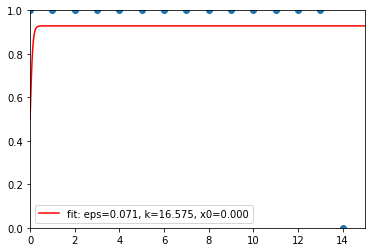

[ 0.         14.25580713 11.49968069]


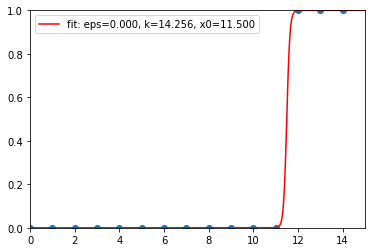

[ 0.         14.2557828   5.49968089]


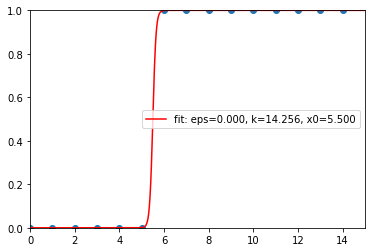

[ 0.         14.25710676  0.49960748]


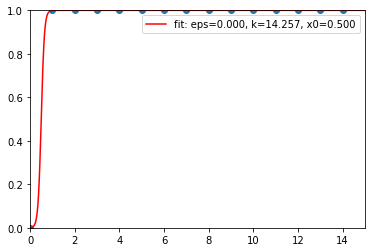

[ 0.         14.25584404  1.49967996]


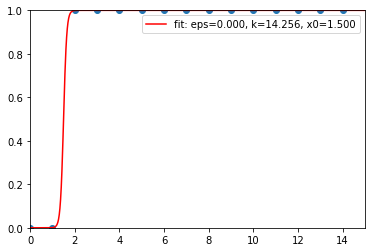

[ 0.         14.25580713 11.49968069]


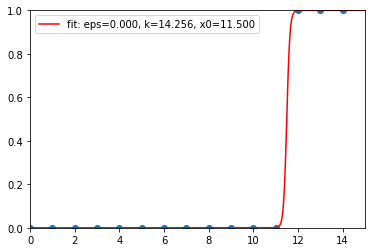

[ 0.          5.0127729  15.41953986]


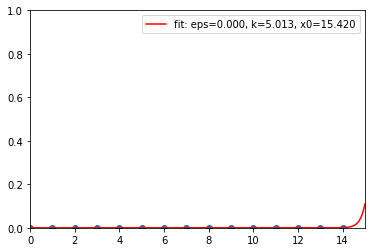

[ 0.         14.25710676  0.49960748]


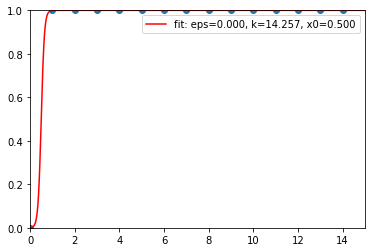

[ 0.         14.25580944  2.49968072]


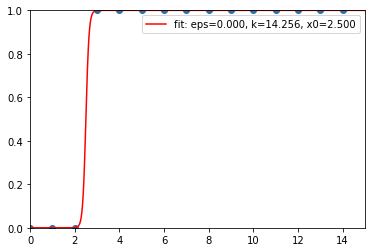

[ 0.06666666 36.13344623  0.54126113]


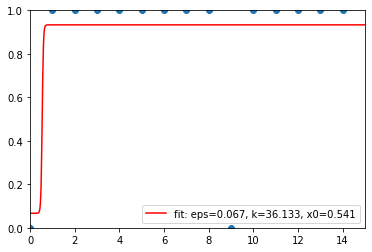

[ 0.         14.25584404  1.49967996]


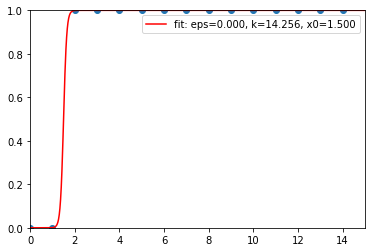

[ 0.         14.25710676  0.49960748]


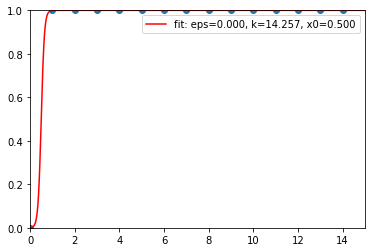

[ 0.         14.25710676  0.49960748]


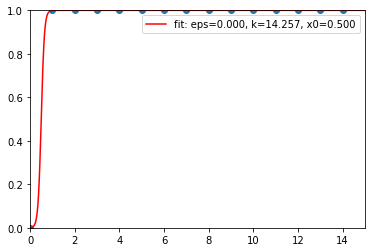

[ 0.         14.25584404  1.49967996]


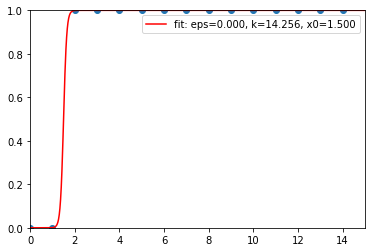

[0.5        5.00164952 0.        ]


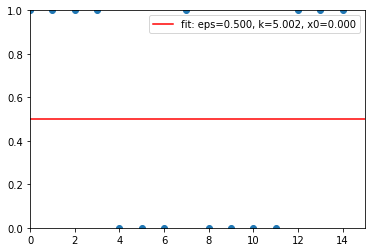

[ 0.         14.25581134  8.49968077]


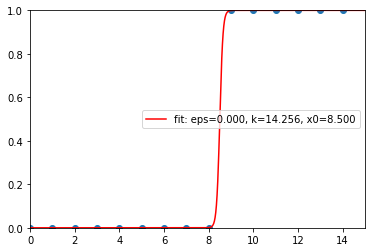

[ 0.20000013 27.54676703  1.50119242]


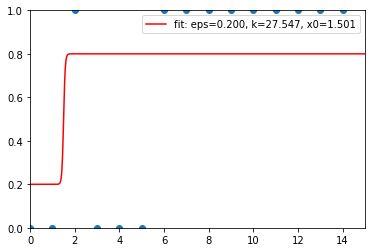

[ 0.33333336 25.12149069  3.50944066]


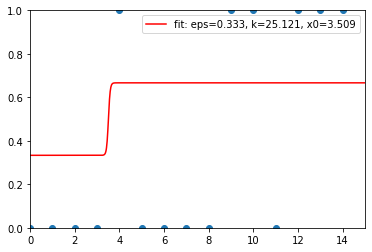

[ 0.28571429 10.32807916  0.        ]


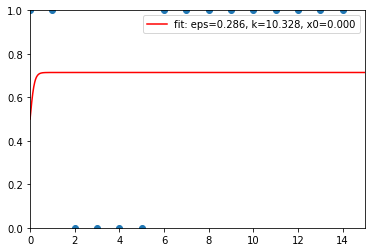

[ 0.         14.25710676  0.49960748]


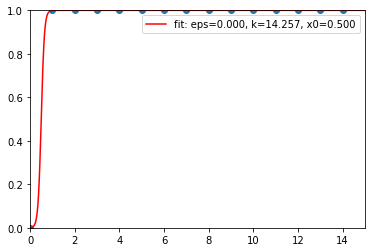

[ 0.         14.25580944  2.49968072]


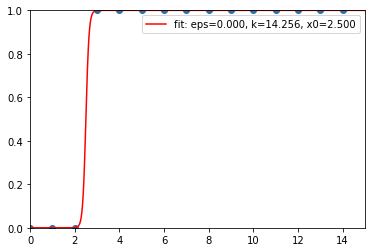

[ 0.         14.25584404  1.49967996]


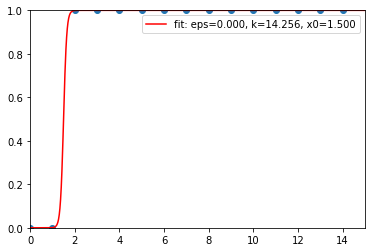

[ 0.33333665 50.60281396  0.66687945]


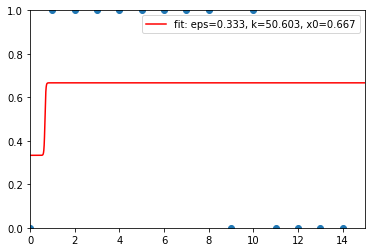

[ 0.         14.25710676  0.49960748]


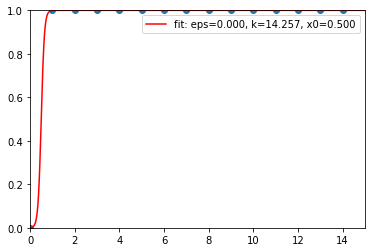

[ 0.         14.25710676  0.49960748]


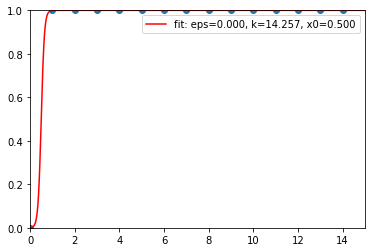

[ 0.19999969 30.21607655  1.50696629]


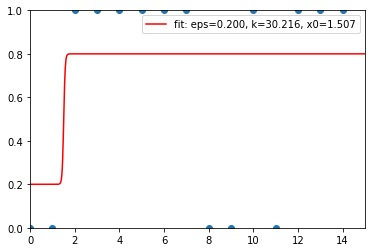

[ 0.42856638 17.89469982  0.        ]


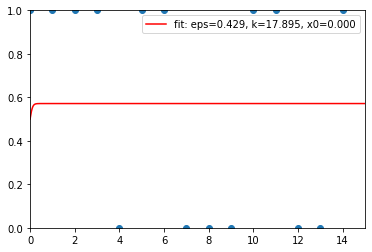

[ 0.06666883 35.83892208  0.53788734]


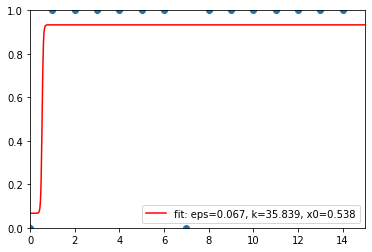

[ 0.         14.25580713 11.49968069]


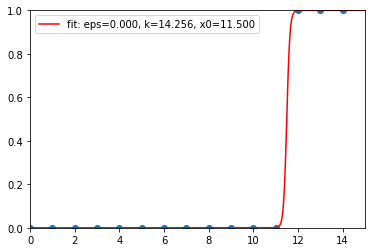

[ 0.         14.25710676  0.49960748]


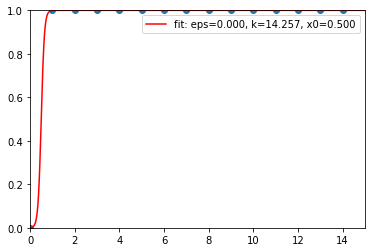

[ 0.         14.25582262  3.49968065]


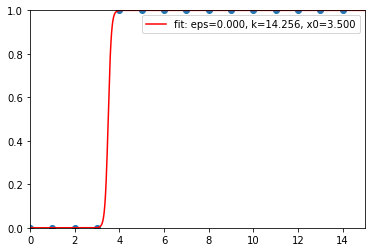

[ 0.         14.25581074  7.49968071]


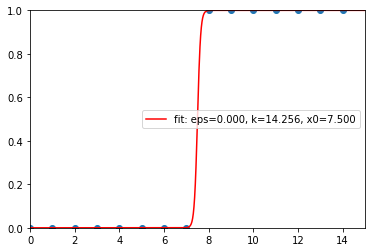

[ 0.         14.25580944  2.49968072]


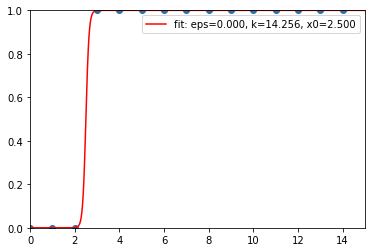

[ 0.         14.25584404  1.49967996]


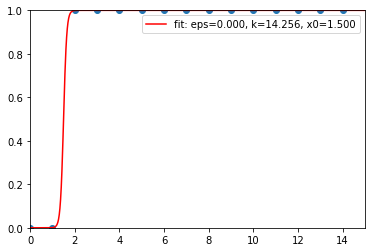

[ 0.         14.25584404  1.49967996]


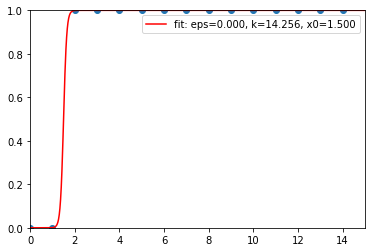

[ 0.06666662 29.39445028  0.46734624]


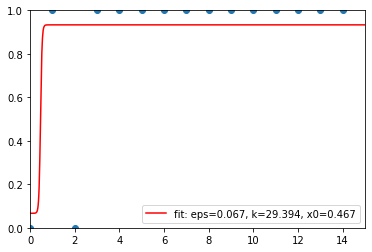

[ 0.         14.25581134  8.49968077]


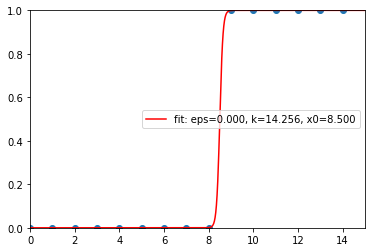

[ 0.         14.25710676  0.49960748]


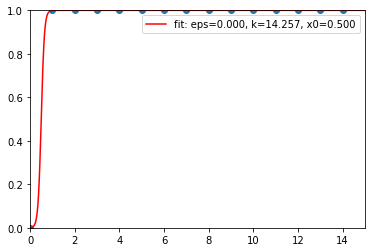

[ 0.         14.25582262  3.49968065]


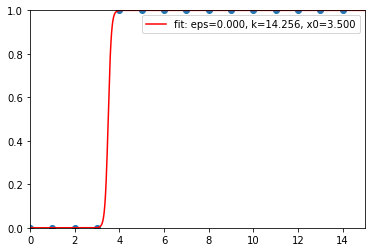

[ 0.         14.25710676  0.49960748]


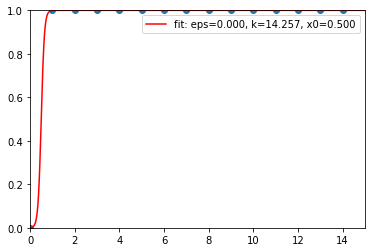

[ 0.19999979 26.98363511  0.50485181]


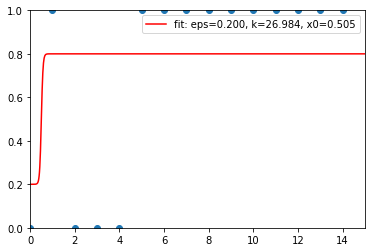

[ 0.         14.25581134  8.49968077]


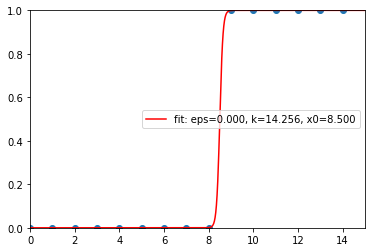

[ 0.         14.25580944  2.49968072]


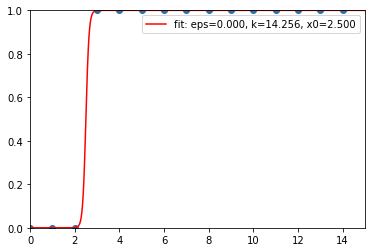

[ 0.         14.25710676  0.49960748]


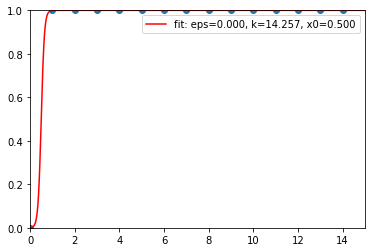

[ 0.13333335 29.47695041  0.52666941]


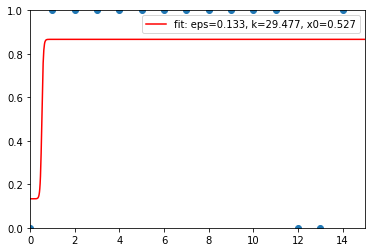

[ 0.         14.25710676  0.49960748]


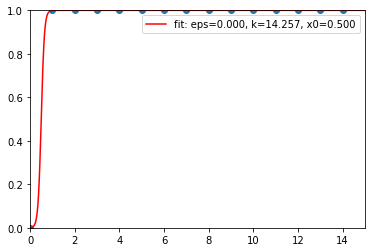

[ 0.         14.25578388  4.49968095]


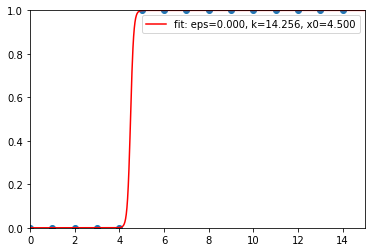

[ 0.         14.25710676  0.49960748]


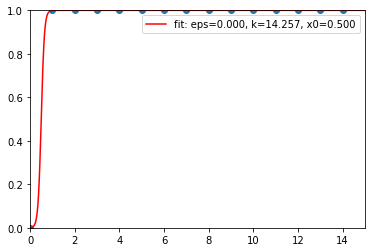

[ 0.06666883 35.83892208  0.53788734]


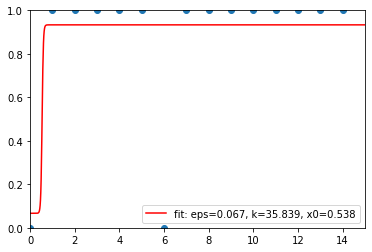

[ 0.         14.25710676  0.49960748]


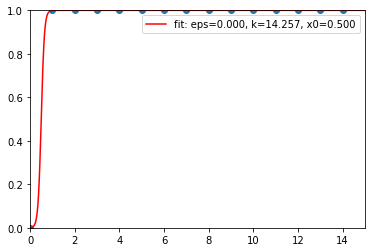

[ 0.06666474 35.34757667  1.48807812]


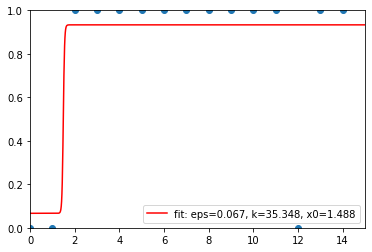

[ 0.         14.25584404  1.49967996]


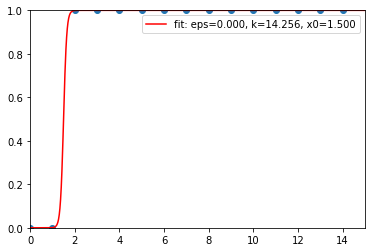

[ 0.06666523 35.40170525  0.54175525]


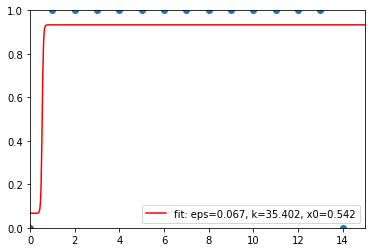

[ 0.33333333 26.46847141  4.50844377]


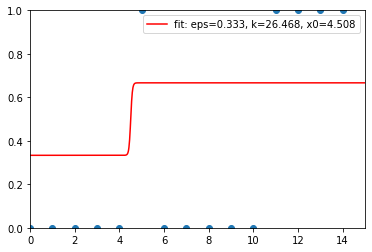

[ 0.07142155 16.83428211  0.        ]


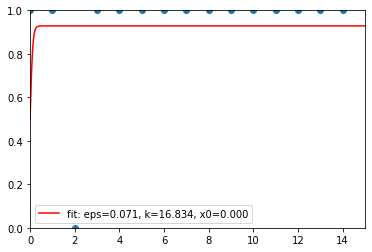

[0.5        4.99521147 5.29016265]


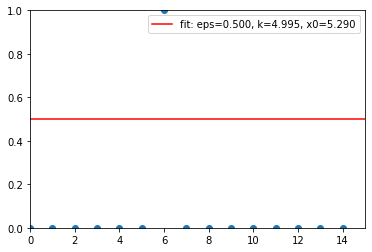

[ 0.26665768 25.14307938  0.52279191]


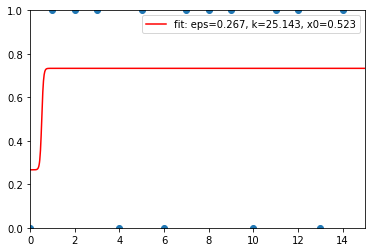

[ 0.06663326 34.530174    8.42905187]


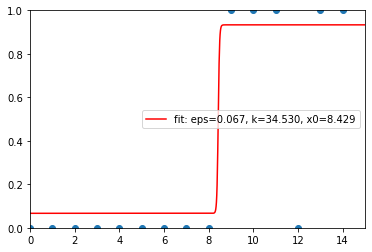

[ 0.20001097 30.80322784  3.50331535]


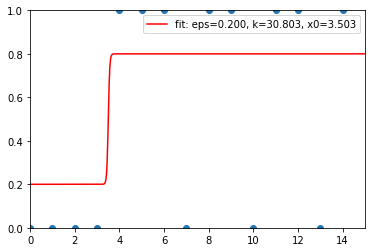

[ 0.26666685 33.51748215  1.50253788]


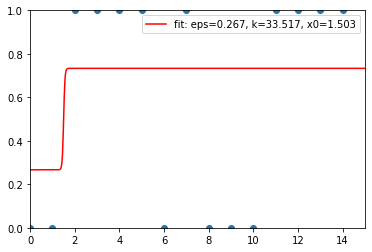

[ 0.1999992  34.2842341   3.50682735]


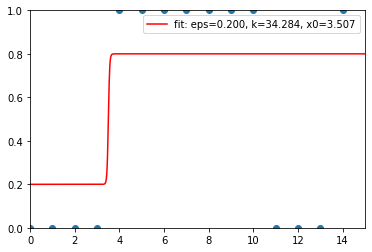

[ 0.          5.0127729  15.41953986]


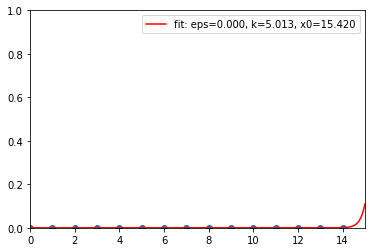

[ 0.13333326 23.95416198  3.50317331]


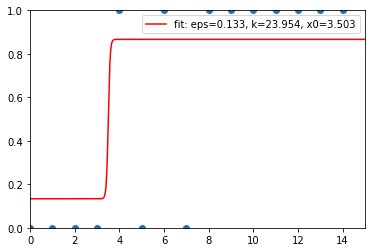

[ 0.13334742 35.58357272  5.51280596]


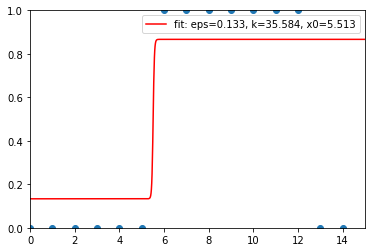

[ 0.         14.25582262  3.49968065]


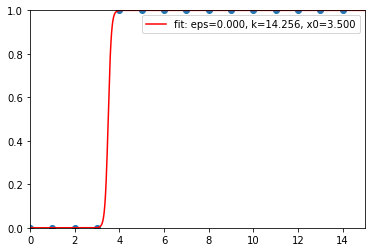

[ 0.26666669 32.40316114  0.53877354]


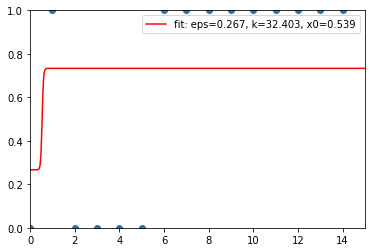

[ 0.         14.21831161 13.49966723]


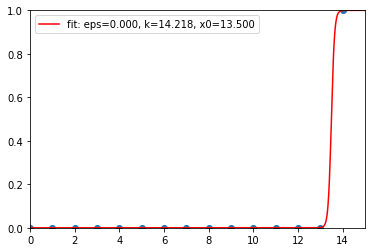

[ 0.2142857 10.9606547  0.       ]


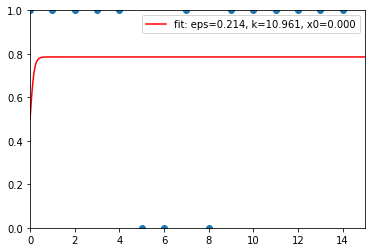

[ 0.20000011 27.70694041  5.49795295]


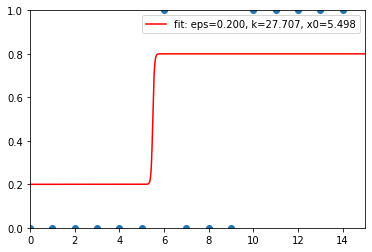

[0.21734222 0.52243338 0.        ]


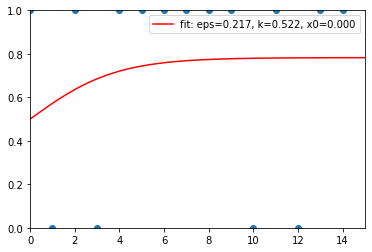

[ 0.28571428 10.96703349  0.        ]


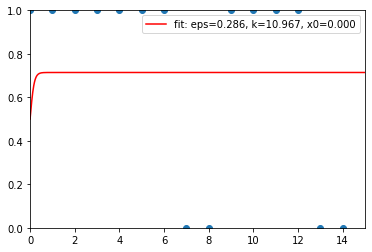

[ 0.06665559 41.48281995  5.38009461]


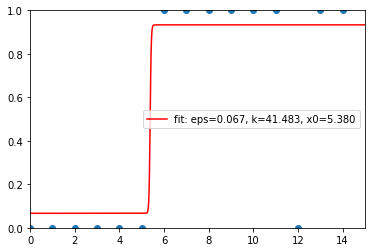

[ 0.13333313 23.95429414  3.50303583]


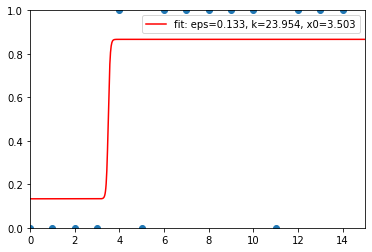

[ 0.26666687 30.59796548  8.52605068]


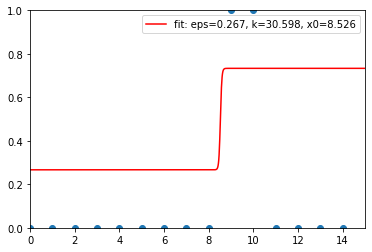

[0.         0.55480564 1.35396795]


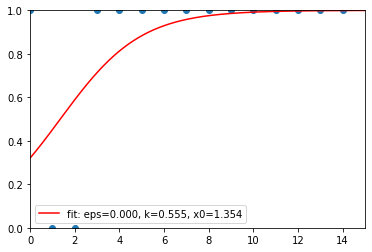

[ 0.         14.25581074  7.49968071]


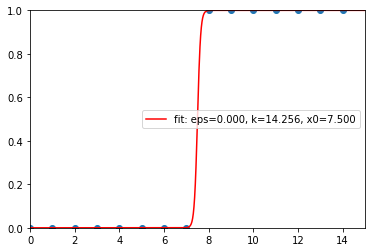

[ 0.28571429 10.96702213  0.        ]


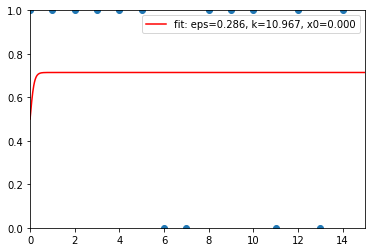

[ 0.26666712 35.68858589  8.5132254 ]


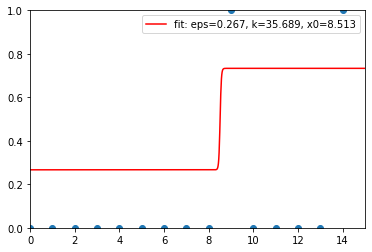

[ 0.06664736 36.88255397  1.44194818]


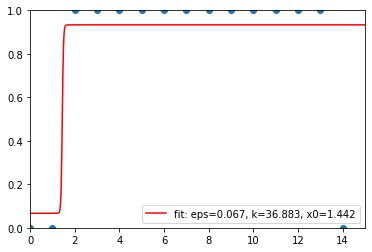

[ 0.35715109 18.52643772  0.        ]


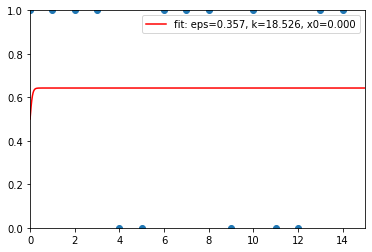

[ 0.13333319 25.36144783  7.50307635]


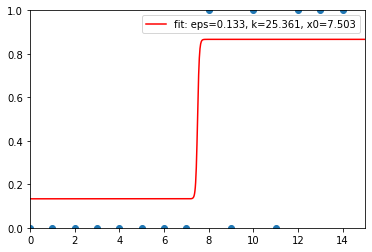

[ 0.26666672 28.53109035  6.52022121]


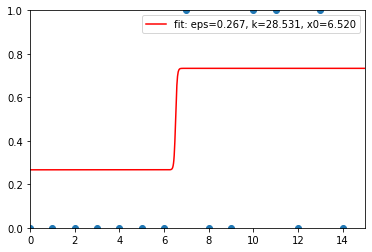

[0.5        4.99518945 0.29010776]


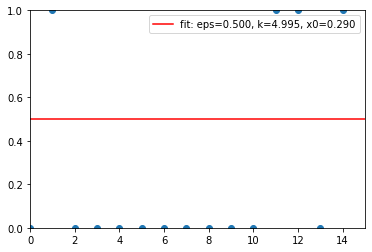

[ 0.         14.25580944  2.49968072]


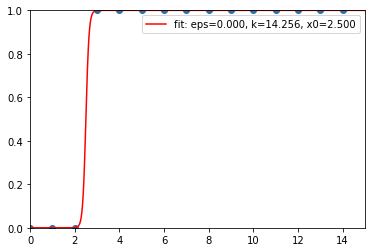

[ 0.         14.25710676  0.49960748]


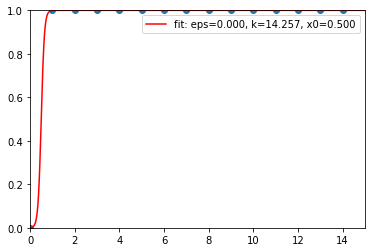

[ 0.         14.25710676  0.49960748]


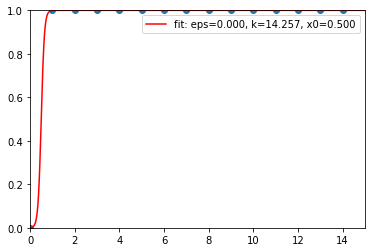

In [45]:
import matplotlib.pyplot as plt

x_bounds = (0, 15)
for block_idx in range(sig_feats.T.shape[1]):
    block_params = sig_feats.T[:3, block_idx]
    trial_data = trial_feats.T[:, block_idx]
    plt.plot(np.linspace(*x_bounds, num=1000),
             sigmoid(np.linspace(*x_bounds, num=1000), *block_params), 'r-',
             label='fit: eps=%5.3f, k=%5.3f, x0=%5.3f' % tuple(block_params))
    print(block_params)
    plt.scatter(range(15), list(trial_data))
    plt.xlim(x_bounds)
    plt.ylim([0, 1])
    plt.legend()
    plt.show()